In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import os
from model import detr_simplified, DETR, DETRModel
from cornell_dataset import CornellDataset
from view_bbox import draw_bbox

In [2]:
model = DETRModel(num_classes=20, num_queries=8)
loaded_model = torch.load("model_389.ckpt")

model.load_state_dict(loaded_model["model"])
model.eval()
m = 0

Using cache found in /home/sbhara/.cache/torch/hub/facebookresearch_detr_main


In [3]:
from torch.utils.data import DataLoader 
dataset_path = "dataset/cornell"
img_set = "train"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
inv_normalize = transforms.Normalize(
                            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                            std=[1/0.229, 1/0.224, 1/0.225])
train_dataset = CornellDataset(dataset_path, "train", normalize)
val_dataset = CornellDataset(dataset_path, "val", normalize)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox).to("cpu")
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [4]:
def iou(box1,box2):
  '''
    Computes the intersection over union of two bounding boxes box = [x1,y1,x2,y2]
    where (x1, y1) and (x2, y2) are the top left and bottom right coordinates respectively
  '''
  x1, y1 = max(box1[0], box2[0]), max(box1[1], box2[1])
  x2, y2 = min(box1[2], box2[2]), min(box1[3], box2[3])
  inter_area = max(0, (x2 - x1 + 1)) * max(0, (y2 - y1 + 1))
  union_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1) + (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1) - inter_area
  return inter_area/union_area

/home/sbhara/Desktop/graspnet/GraspFormer/cornell_dataset.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_class_bbox = [torch.tensor(gt_class), torch.tensor(gt_bbox/224)]
/home/sbhara/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


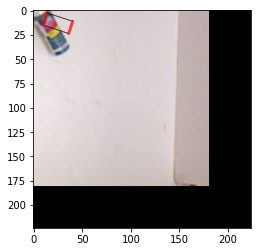

IOU: 0.2644052057866597, GT: tensor([13], dtype=torch.int32), tensor([[ 0.0000,  1.1973, 48.6284, 31.3807]], dtype=torch.float64) Class: 13, bboxes: tensor([[10.9566,  6.1459, 38.6691, 19.3972]])


<Figure size 432x288 with 0 Axes>

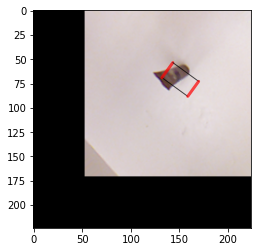

IOU: 0.36492349654666434, GT: tensor([15], dtype=torch.int32), tensor([[127.2232,  59.6787, 155.4884,  73.8113]], dtype=torch.float64) Class: 15, bboxes: tensor([[134.4830,  61.1648, 167.3287,  80.2661]])


<Figure size 432x288 with 0 Axes>

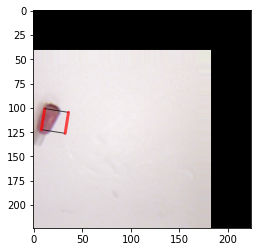

IOU: 0.43979184505412083, GT: tensor([12], dtype=torch.int32), tensor([[  0.0000,  97.9184,  38.5149, 118.7155]], dtype=torch.float64) Class: 12, bboxes: tensor([[  9.3835, 102.5055,  34.1464, 124.4154]])


<Figure size 432x288 with 0 Axes>

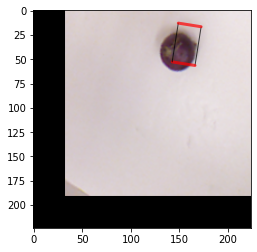

IOU: 0.36049180793721547, GT: tensor([2], dtype=torch.int32), tensor([[114.3298,  30.5328, 185.6649,  51.7104]], dtype=torch.float64) Class: 2, bboxes: tensor([[137.2423,  22.5559, 177.6589,  46.3717]])


<Figure size 432x288 with 0 Axes>

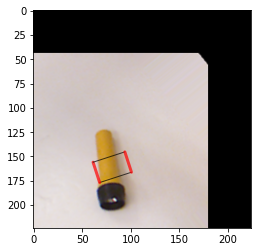

IOU: 0.14494316439649377, GT: tensor([9], dtype=torch.int32), tensor([[ 54.3299, 137.7539,  92.2304, 155.7067]], dtype=torch.float64) Class: 9, bboxes: tensor([[ 63.6082, 150.0679,  98.0292, 172.1096]])


<Figure size 432x288 with 0 Axes>

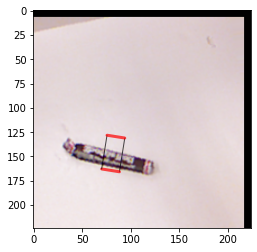

IOU: 0.26138192001674593, GT: tensor([2], dtype=torch.int32), tensor([[ 77.4361, 143.2143, 118.7470, 162.1950]], dtype=torch.float64) Class: 2, bboxes: tensor([[ 64.2102, 137.6871,  99.4098, 156.2163]])


<Figure size 432x288 with 0 Axes>

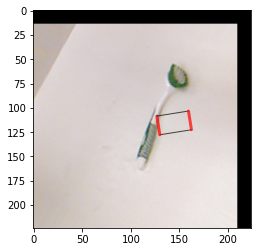

IOU: 0.2626163011313277, GT: tensor([10], dtype=torch.int32), tensor([[113.1988,  95.3130, 144.1752, 125.3214]], dtype=torch.float64) Class: 10, bboxes: tensor([[128.0554, 105.6808, 161.0710, 125.2122]])


<Figure size 432x288 with 0 Axes>

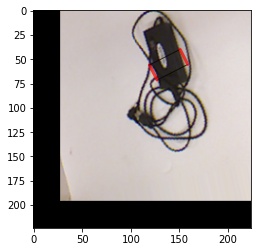

IOU: 0.68846551563369, GT: tensor([8], dtype=torch.int32), tensor([[121.2577,  41.9462, 156.4054,  61.8949]], dtype=torch.float64) Class: 8, bboxes: tensor([[121.1679,  46.7936, 156.5960,  64.1908]])


/home/sbhara/Desktop/graspnet/GraspFormer/box_util.py:82: RuntimeWarning: invalid value encountered in true_divide
  delta_area = ((ar_ - bbox_area(bbox))/ar_)


<Figure size 432x288 with 0 Axes>

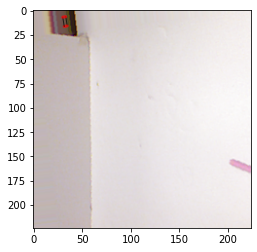

IOU: 0.0, GT: tensor([0], dtype=torch.int32), tensor([[40., 40., 40., 40.]], dtype=torch.float64) Class: 0, bboxes: tensor([[27.2673,  9.4739, 36.9504, 12.5939]])


<Figure size 432x288 with 0 Axes>

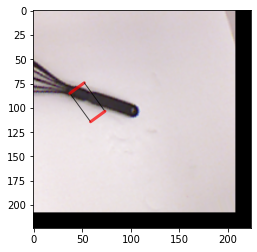

IOU: 0.2747681931647852, GT: tensor([17], dtype=torch.int32), tensor([[40.4145, 79.1995, 88.6020, 93.3032]], dtype=torch.float64) Class: 17, bboxes: tensor([[ 37.0754,  84.9953,  73.3688, 103.3914]])
Mean IoU: 30.61787449667703, accuracy: 100.0


<Figure size 432x288 with 0 Axes>

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
final_iou = 0
correct_pred = 0
for i, (x_val, y_val) in enumerate(train_loader):
    x_val = x_val.to(device)
    box = y_val
    output = model(x_val)
    bbox = output["pred_boxes"]
    labels = output["pred_logits"]

    probas = labels.softmax(-1)
    #print( bbox * 224)
    probas = torch.argmax(probas, dim=2, keepdim=True)
    idx = torch.argmax(probas)

    pred_class = probas[:, idx].squeeze().cpu().numpy()
    bbox_pred = bbox[:, idx].detach().cpu() * 224

    x_val = inv_normalize(x_val)

    draw_func = draw_bbox(bbox_pred.squeeze(0).detach().cpu().numpy(), pred_class)
    draw_func.draw_rotated_box(x_val[0].permute(1, 2, 0).cpu().numpy())
    iou_calc = iou(y_val[1].squeeze(0).detach().cpu().numpy()*224, bbox_pred.squeeze(0).detach().cpu().numpy())
    final_iou += iou_calc
    if pred_class == y_val[0].numpy():
        correct_pred += 1

    print(f"IOU: {iou_calc}, GT: {y_val[0]}, {y_val[1]*224} Class: {pred_class}, bboxes: {bbox_pred}")
    i+=1
    if i == 10:
        print(f"Mean IoU: {final_iou/i * 100}, accuracy: {correct_pred/i * 100}")
        break
    